Final Project w207

Matthew Holmes
Andrew Kabatznick
Grant Whittington

Data from: https://www.kaggle.com/c/bike-sharing-demand/data

In [87]:
%matplotlib inline

##basically just importanting most of the libraries from previous assignments

import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from sklearn import tree
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [88]:
def transform_raw_data(raw_input):
    #Putting Data into Pandas dataframe
        Column_Headers = csvfile.readline().split(',')
        Column_Headers[-1] = "count"
        csvfile.next()
        train_data = []
        for row in csvfile:
            new_row = row.replace('\n', '')
            train_data.append(new_row.split(','))
        
        df = pd.DataFrame(data = train_data[1:-1], columns = Column_Headers)
        return df

In [89]:
with open('train.csv') as csvfile:
    train_data = transform_raw_data(csvfile)
with open('test.csv') as csvfile:
    test_data = transform_raw_data(csvfile)

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
1,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
2,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1
3,2011-01-01 05:00:00,1,0,0,2,9.84,12.88,75,6.0032,0,1,1
4,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0,2,0,2


In [90]:
##Feature Modification
def modify_factors(input_data):
    output_data=pd.DataFrame(input_data)
    
    ##Split datetime into year, month, day, and hour columns
    rawdate = input_data['datetime']
    
    #Initialize new columns
    output_data['year']=0
    output_data['month']=0
    output_data['day']=0
    output_data['hour']=0
    output_data['past_hour']=0 
    
    for i in range(len(rawdate)):
        
        #Use number of rentals for previous day/hour as predictors
        if i>=1:
            output_data['past_hour'].iloc[i]=output_data['count'].iloc[i-1]
        
        [date,hour] = rawdate.iloc[i].split()
        [year,month,day] = date.split("-")
        
        output_data['year'].iloc[i] = int(year)
        output_data['month'].iloc[i]=int(month)
        output_data['day'].iloc[i]=int(day)
        output_data['hour'].iloc[i]=int(hour[:2])
        
        
        #Split day into before, during and after work periods (after work in "intercept")
        output_data['before_work']=0
        output_data['during_work']=0
        
        if output_data['hour'].iloc[i]<9: 
            output_data['before_work'].iloc[i]=1
        elif output_data['hour'].iloc[i]<=17:
            output_data['during_work'].iloc[i]=1
            
        
    ##One hot encoding for season, weather
    season_onehot = pd.get_dummies(input_data['season'])
    season_onehot.columns = ["winter", "spring", "summer", "autumn"]
    output_data = pd.concat([output_data,season_onehot],axis=1)
    
    weather_onehot = pd.get_dummies(input_data['weather'])
    weather_onehot.columns = ["clear", "misty", "light_precip", "heavy_precip"]
    output_data = pd.concat([output_data,weather_onehot],axis=1)

    
    del output_data['datetime']
    del output_data['season']
    del output_data['weather']
    
    #Remove Dependent Columns
    del output_data['clear']
    del output_data['spring']
    
    return output_data

In [91]:
train_data = modify_factors(train_data)

In [92]:
train_data.head(5)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,...,hour,past_hour,before_work,during_work,winter,summer,autumn,misty,light_precip,heavy_precip
0,0,0,9.02,13.635,80,0,5,27,32,2011,...,2,0,0,0,1,0,0,0,0,0
1,0,0,9.84,14.395,75,0,3,10,13,2011,...,3,0,0,0,1,0,0,0,0,0
2,0,0,9.84,14.395,75,0,0,1,1,2011,...,4,13,0,0,1,0,0,0,0,0
3,0,0,9.84,12.88,75,6.0032,0,1,1,2011,...,5,1,0,0,1,0,0,1,0,0
4,0,0,9.02,13.635,80,0,2,0,2,2011,...,6,1,0,0,1,0,0,0,0,0


In [93]:
#Splitting Columns into Prediction and Numerical vs Categorical
All_Columns = list(train_data.columns.values)
Prediction_Columns = All_Columns[:]
Prediction_Columns.remove('registered')
Prediction_Columns.remove('casual')
Prediction_Columns.remove('count')
Numerical_Predictors = Prediction_Columns[0:10 or None]
Categorical_Predictors = Prediction_Columns[11:-0 or None]

##Removing Time based factors
Standard_Prediction_Columns = Prediction_Columns[:]
Standard_Prediction_Columns.remove('hour')
Standard_Prediction_Columns.remove('day')
Standard_Prediction_Columns.remove('month')
Standard_Prediction_Columns.remove('year')

In [94]:
#train, dev, test split of base data
def data_split(data,train_percent,dev_percent,is_random):
    size_of_data=len(data)
    train_amount=int(round(train_percent*size_of_data))
    dev_amount=int(round(dev_percent*size_of_data))
    train, dev, test = np.split(data.sample(frac=1), [train_amount, train_amount+dev_amount])
    return train,dev,test


In [95]:
[train_set,dev_set,test_set]=data_split(train_data,.8,0.0,1)

In [96]:
##Function to determine model fit quality
def fit_evaluation(actual,predicted):
    intval = 0.0
    amount = len(predicted)
    for i in range(len(predicted)):
        intval+=(math.log(float(predicted[i])+1.0)-math.log(float(actual[i])+1.0))**2
    val = (1/float(amount)*intval)**.5
    return val

In [97]:
##Convert that function into a modified scorer
from sklearn.metrics import fbeta_score,make_scorer
from sklearn.dummy import DummyClassifier

log_score = make_scorer(fit_evaluation,greater_is_better=False)

0.718927415912


(0, 1000)

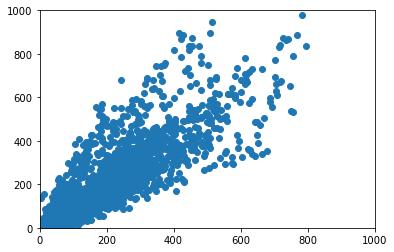

In [98]:
#Basic Linear Regression
LinearReg = LinearRegression()
LinearReg.fit(train_set[Prediction_Columns], train_set['count'])
print LinearReg.score(test_set[Prediction_Columns], test_set['count'])

predicted = LinearReg.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
##print fit_evaluation(test_set['count'].values,predicted)

0.712627324257


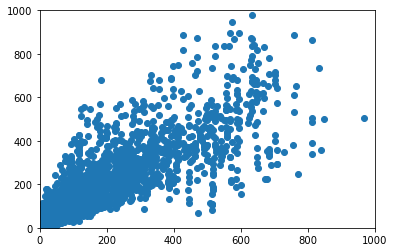

In [99]:
#Multinomial Naive Bayes
MultiBayes = MultinomialNB()
MultiBayes.fit(train_set[Prediction_Columns], train_set['count'])

predicted = MultiBayes.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
print fit_evaluation(test_set['count'].values,predicted)

0.376607113922


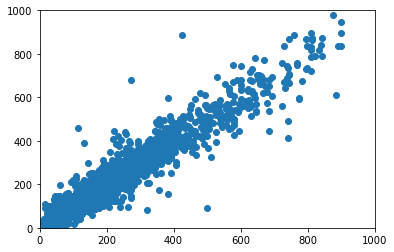

In [100]:
#Decision Trees
DTree = tree.DecisionTreeRegressor()
DTree.fit(train_set[Prediction_Columns], train_set['count'])

predicted = DTree.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
print fit_evaluation(test_set['count'].values,predicted)

In [103]:
param_grid = {'max_depth':range(1,20),'max_features':range(1,20)}
PTree = tree.DecisionTreeRegressor()
param_search = GridSearchCV(PTree,param_grid,cv=7,scoring=log_score)
param_search.fit(train_set[Prediction_Columns].values, train_set['count'].values)
predicted = param_search.predict(train_set[Prediction_Columns])

{'max_features': 18, 'max_depth': 10}
0.332076828349


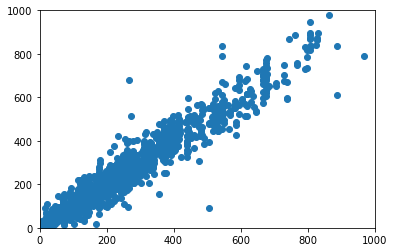

In [104]:
print param_search.best_params_
predicted = param_search.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
print fit_evaluation(test_set['count'].values,predicted)